# LSTM with base stock market data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import os
import sys
import numpy as np
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

import src.preprocess_data as preprocess_data

importlib.reload(preprocess_data)

# Set seeds for reproducibility
np.random.seed(0)
torch.manual_seed(0)

# Set PyTorch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
DATA_PATH = "../data/processed/stocks.csv"

FOCUS_PRICE = "Close"
FOCUS_STOCK = "AAPL"

WINDOW_SIZE = 3
BATCH_SIZE = 16
LEARNING_RATE = 0.001
EPOCHS = 5000

LSTM_HIDDEN_SIZE = 2
LSTM_NUM_LAYERS = 1

## Data Preparation

### Processing

In [3]:
df_stocks = pd.read_csv(DATA_PATH)

# TODO: Expand this or use tweets from a larger period of time
df_stocks = df_stocks[df_stocks["Name"] == FOCUS_STOCK]

df_stocks = df_stocks[["Date", FOCUS_PRICE]]
df_stocks["Date"] = df_stocks["Date"].apply(preprocess_data.convert_date)

df_stocks.set_index("Date", inplace=True)

df_stocks = preprocess_data.apply_time_window(df = df_stocks,
                                              price_col_name=FOCUS_PRICE,
                                              n = WINDOW_SIZE)

df_stocks.head(10)

,Close,Close-3,Close-2,Close-1
Date,,,,
2009-04-09,17.081429,16.921429,16.428572,16.617144
2009-04-13,17.174286,16.428572,16.617144,17.081429
2009-04-14,16.901428,16.617144,17.081429,17.174286
2009-04-15,16.805714,17.081429,17.174286,16.901428
2009-04-16,17.350000,17.174286,16.901428,16.805714
2009-04-17,17.631428,16.901428,16.805714,17.350000
2009-04-20,17.214285,16.805714,17.350000,17.631428
2009-04-21,17.394285,17.350000,17.631428,17.214285
2009-04-22,17.358572,17.631428,17.214285,17.394285


### Conversion to PyTorch, data splitting

In [4]:
Xy = df_stocks.to_numpy()
X = Xy[:, 1:]
X = np.expand_dims(X, axis=-1)

y = Xy[:, :1]

print(X.shape, y.shape)

(54, 3, 1) (54, 1)


In [5]:
split = int(len(X) * 0.8)

X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([43, 3, 1]) torch.Size([43, 1])
torch.Size([11, 3, 1]) torch.Size([11, 1])


### Dataset and DataLoaders

In [6]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.len = len(X)

    def __len__(self):
        return self.len
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [7]:
train_dataset = StockDataset(X_train, y_train)
test_dataset = StockDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Modelling

### Model

In [8]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)

        h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

        x, _ = self.lstm(x, (h_0, c_0))
        x = self.fc(x[:, -1, :])
        
        return x

### Training

In [9]:
model = LSTM(input_size=1,
             hidden_size=LSTM_HIDDEN_SIZE,
             num_layers=LSTM_NUM_LAYERS).to(device)

loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

for epoch in range(EPOCHS):
    model.train(True)

    train_loss = 0
    cnt = 0
    for i, batch in enumerate(train_dataloader):
        X, y = batch[0].to(device), batch[1].to(device)

        out = model(X)
        l = loss(out, y)
        train_loss += l

        optimizer.zero_grad()
        l.backward()
        optimizer.step()

        cnt += 1

    train_loss /= cnt

    model.train(False)

    val_loss = 0
    cnt = 0
    for i, batch in enumerate(test_dataloader):
        X, y = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            out = model(X)
            l = loss(out, y)

            val_loss += l

        cnt += 1

    val_loss /= cnt

    if epoch % 100 == 0:
        print(f"[ Epoch {epoch} / {EPOCHS} ] Train loss = {train_loss} Val loss = {val_loss}")

[ Epoch 0 / 5000 ] Train loss = 342.98388671875 Val loss = 389.6722717285156
[ Epoch 100 / 5000 ] Train loss = 299.5494079589844 Val loss = 341.05963134765625
[ Epoch 200 / 5000 ] Train loss = 262.9285583496094 Val loss = 300.3456726074219
[ Epoch 300 / 5000 ] Train loss = 232.618896484375 Val loss = 269.3547058105469
[ Epoch 400 / 5000 ] Train loss = 206.0779571533203 Val loss = 241.627685546875
[ Epoch 500 / 5000 ] Train loss = 183.793212890625 Val loss = 216.3517608642578
[ Epoch 600 / 5000 ] Train loss = 162.09088134765625 Val loss = 193.1650390625
[ Epoch 700 / 5000 ] Train loss = 141.80633544921875 Val loss = 171.83009338378906
[ Epoch 800 / 5000 ] Train loss = 125.19979095458984 Val loss = 152.1999053955078
[ Epoch 900 / 5000 ] Train loss = 108.81571197509766 Val loss = 134.15667724609375
[ Epoch 1000 / 5000 ] Train loss = 94.5049819946289 Val loss = 117.60900115966797
[ Epoch 1100 / 5000 ] Train loss = 80.62177276611328 Val loss = 102.46875
[ Epoch 1200 / 5000 ] Train loss = 67

## Evaluation

Text(0.5, 1.0, 'Test data')

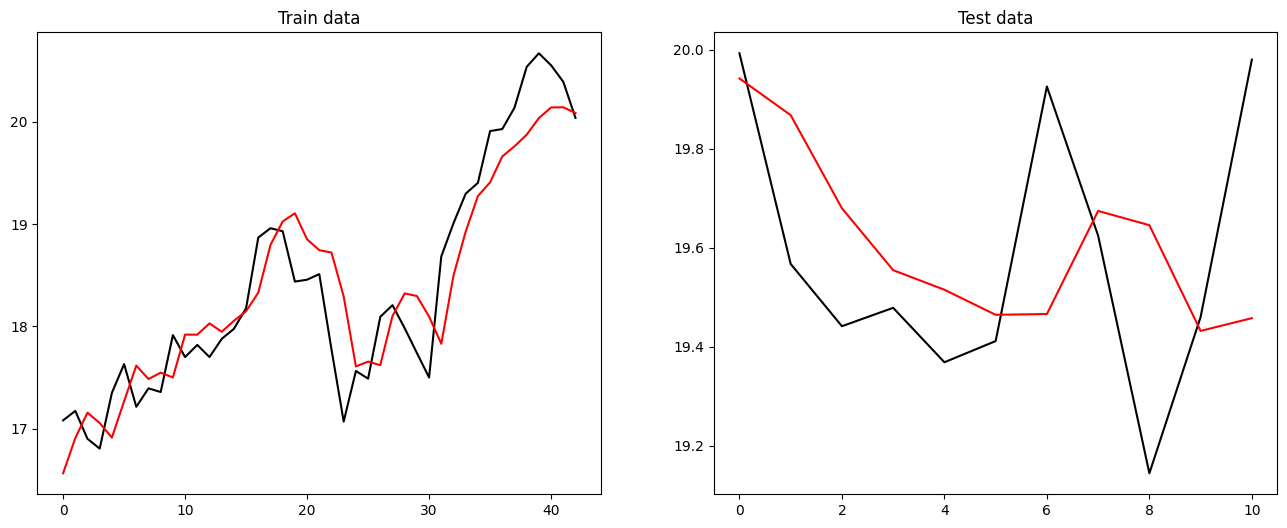

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

with torch.no_grad():
    y_pred = model(X_train.to(device)).to("cpu")
    y_pred = np.array(y_pred)

ax[0].plot(y_train, color="black", label = "True")
ax[0].plot(y_pred, color="red", label = "Predicted")
ax[0].set_title("Train data")

with torch.no_grad():
    y_pred = model(X_test.to(device)).to("cpu")
    y_pred = np.array(y_pred)

ax[1].plot(y_test, color="black", label = "True")
ax[1].plot(y_pred, color="red", label = "Predicted")
ax[1].set_title("Test data")
